## Домашняя работа №6

Провести сравнение RNN, LSTM, GRU на датасете отзывов (из предыдущих занятий/материалов).

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=Warning)

### Загрузка и обзор данных

In [2]:
data = pd.read_excel("отзывы за лето.xls")
data.head()

,Rating,Content,Date
0,5,It just works!,2017-08-14
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14
2,5,Отлично все,2017-08-14
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14
4,5,"Очень удобно, работает быстро.",2017-08-14


In [3]:
data['Rating'].value_counts()

5    14586
1     2276
4     2138
3      911
2      748
Name: Rating, dtype: int64

In [4]:
data = data[data['Rating'] != 3]
data['target'] = data['Rating'] > 3
data['target'] = data['target'].astype(int)

### Обработка текстов

In [5]:
!pip install pymorphy2

In [6]:
import nltk
from nltk.tokenize import word_tokenize

from pymorphy2 import MorphAnalyzer

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
punctuation = r'[,.]'
morpher = MorphAnalyzer()

stop = {'без', 'безо', 'близ', 'в', 'во', 'вместо', 'вне',
        'для', 'до', 'за', 'из', 'изо', 'из-за', 'из-под', 
        'к', 'ко', 'кроме', 'между', 'меж', 'на', 'над', 'надо',
        'о', 'об', 'обо', 'от', 'ото', 'перед', 'передо', 'пред', 'предо',
        'пo', 'под', 'подо', 'при', 'про', 'ради', 'с', 'со',
        'сквозь', 'среди', 'у', 'через', 'чрез'}

In [9]:
def normalize_text(text_list):
    return [morpher.parse(word)[0].normal_form \
            for word in text_list if word not in stop]

def preprocess_text(text):    
    text_list = nltk.word_tokenize(str(text))
    text_list = normalize_text(text_list)
    return text_list

In [10]:
data['Text'] = data['Content'].str.lower()
data['Text'] = data['Text'].str.replace(r'[.,]', ' ')
data['Text'] = [preprocess_text(text_list) for text_list in tqdm(data['Text'])]

100%|██████████| 19748/19748 [00:32<00:00, 601.73it/s]


In [11]:
data['Text'] = data['Text'].str.join(' ')
data.head(10)

,Rating,Content,Date,target,Text
0,5,It just works!,2017-08-14,1,it just works !
1,4,В целом удобноное приложение...из минусов хотя...,2017-08-14,1,целое удобноной приложение минус хотеть слишко...
2,5,Отлично все,2017-08-14,1,отлично всё
3,5,Стал зависать на 1% работы антивируса. Дальше ...,2017-08-14,1,стать зависать 1 % работа антивирус далёкий ни...
4,5,"Очень удобно, работает быстро.",2017-08-14,1,очень удобно работать быстро
5,5,Всё удобно норм 👍👍👍,2017-08-14,1,всё удобно норма 👍👍👍
6,5,Очень удобное приложение.,2017-08-14,1,очень удобный приложение
7,5,Все устраивает,2017-08-14,1,всё устраивать
8,5,У меня работает все четко. В отличии от банком...,2017-08-14,1,я работать всё чётко отличие банкомат который ...
9,5,Очень все хорошо👍,2017-08-14,1,очень всё хорошо👍


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = data['Text']
y = data['target']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

In [15]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Embedding, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [16]:
train_corpus = X_train.values
test_corpus = X_test.values

In [17]:
tokenizer = Tokenizer(num_words=None, 
                      filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                      lower = False, split = ' ')
tokenizer.fit_on_texts(train_corpus)

sequences_train = tokenizer.texts_to_sequences(train_corpus)
sequences_test = tokenizer.texts_to_sequences(test_corpus)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in train_corpus])

X_train_sequanced = pad_sequences(sequences_train, maxlen=training_length)
X_test_sequanced = pad_sequences(sequences_test, maxlen=training_length)

### Обучение RNN

In [18]:
model1 = Sequential()
model1.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model1.add(Masking(mask_value=0.0))
model1.add(SimpleRNN(64))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [19]:
history1 = model1.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 60s 45ms/step - loss: 0.2352 - accuracy: 0.9010 - val_loss: 0.2302 - val_accuracy: 0.8995
Epoch 2/10
1333/1333 [==============================] - 61s 45ms/step - loss: 0.1636 - accuracy: 0.9344 - val_loss: 0.2254 - val_accuracy: 0.9123
Epoch 3/10
1333/1333 [==============================] - 62s 46ms/step - loss: 0.1304 - accuracy: 0.9499 - val_loss: 0.2614 - val_accuracy: 0.9096
Epoch 4/10
1333/1333 [==============================] - 61s 46ms/step - loss: 0.1026 - accuracy: 0.9612 - val_loss: 0.2681 - val_accuracy: 0.9184
Epoch 5/10
1333/1333 [==============================] - 65s 49ms/step - loss: 0.0844 - accuracy: 0.9697 - val_loss: 0.2633 - val_accuracy: 0.9130
Epoch 6/10
1333/1333 [==============================] - 64s 48ms/step - loss: 0.0879 - accuracy: 0.9698 - val_loss: 0.2926 - val_accuracy: 0.9150
Epoch 7/10
1333/1333 [==============================] - 62s 46ms/step - loss: 0.0648 - accuracy: 0.9775 - val_loss: 0.3223 -

In [20]:
loss, acc = model1.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 5s 10ms/step - loss: 0.2781 - accuracy: 0.8997


### Обучение LSTM

In [21]:
model2 = Sequential()
model2.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model2.add(Masking(mask_value=0.0))
model2.add(LSTM(64, recurrent_dropout=0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [22]:
history2 = model2.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 222s 167ms/step - loss: 0.2193 - accuracy: 0.9100 - val_loss: 0.2020 - val_accuracy: 0.9082
Epoch 2/10
1333/1333 [==============================] - 229s 171ms/step - loss: 0.1341 - accuracy: 0.9486 - val_loss: 0.2191 - val_accuracy: 0.9211
Epoch 3/10
1333/1333 [==============================] - 225s 169ms/step - loss: 0.0977 - accuracy: 0.9639 - val_loss: 0.2033 - val_accuracy: 0.9197
Epoch 4/10
1333/1333 [==============================] - 226s 169ms/step - loss: 0.0751 - accuracy: 0.9746 - val_loss: 0.2507 - val_accuracy: 0.9136
Epoch 5/10
1333/1333 [==============================] - 226s 169ms/step - loss: 0.0588 - accuracy: 0.9809 - val_loss: 0.2568 - val_accuracy: 0.9150
Epoch 6/10
1333/1333 [==============================] - 225s 169ms/step - loss: 0.0458 - accuracy: 0.9850 - val_loss: 0.3518 - val_accuracy: 0.9062
Epoch 7/10
1333/1333 [==============================] - 224s 168ms/step - loss: 0.0419 - accuracy: 0.9858 - val_

In [23]:
loss, acc = model2.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 11s 21ms/step - loss: 0.5043 - accuracy: 0.9135


### Обучение GRU

In [24]:
model3 = Sequential()
model3.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
model3.add(Masking(mask_value=0.0))
model3.add(GRU(64, recurrent_dropout=0.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

In [25]:
history3 = model3.fit(X_train_sequanced, y_train,
                      batch_size=10,
                      epochs=10,
                      verbose=1,
                      validation_split=0.1)

Epoch 1/10
1333/1333 [==============================] - 192s 144ms/step - loss: 0.2204 - accuracy: 0.9054 - val_loss: 0.2079 - val_accuracy: 0.9150
Epoch 2/10
1333/1333 [==============================] - 191s 143ms/step - loss: 0.1327 - accuracy: 0.9494 - val_loss: 0.1838 - val_accuracy: 0.9211
Epoch 3/10
1333/1333 [==============================] - 191s 143ms/step - loss: 0.0935 - accuracy: 0.9636 - val_loss: 0.2700 - val_accuracy: 0.9177
Epoch 4/10
1333/1333 [==============================] - 194s 145ms/step - loss: 0.0718 - accuracy: 0.9759 - val_loss: 0.2199 - val_accuracy: 0.9238
Epoch 5/10
1333/1333 [==============================] - 196s 147ms/step - loss: 0.0554 - accuracy: 0.9808 - val_loss: 0.2495 - val_accuracy: 0.9116
Epoch 6/10
1333/1333 [==============================] - 210s 158ms/step - loss: 0.0431 - accuracy: 0.9861 - val_loss: 0.3096 - val_accuracy: 0.9170
Epoch 7/10
1333/1333 [==============================] - 205s 154ms/step - loss: 0.0358 - accuracy: 0.9874 - val_

In [26]:
loss, acc = model3.evaluate(X_test_sequanced, y_test, batch_size=10, verbose=1)

494/494 [==============================] - 10s 20ms/step - loss: 0.4670 - accuracy: 0.9149


### Визуализация

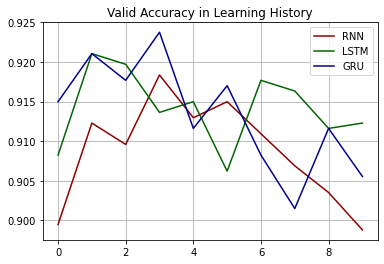

In [27]:
plt.plot(history1.history['val_accuracy'], label='RNN', c='darkred')
plt.plot(history2.history['val_accuracy'], label='LSTM', c='darkgreen')
plt.plot(history3.history['val_accuracy'], label='GRU', c='darkblue')
plt.title('Valid Accuracy in Learning History')
plt.legend(loc='best')
plt.grid(True)
plt.show()